Download genes from: https://www.oncokb.org/cancer-genes (read the .tsv)  
Then filter via the Vogelstein et al. (2013). column   
Then create a parquet with similar columns to kaggle/input/oncokb-cancer-gene-list/mutations_3.parquet

From BiolSys - zajęcia:

## 1. Przygotowanie danych:

## OncoKB database:

In [1]:
import pandas as pd

oncokb_df = pd.read_csv('/kaggle/input/oncokb-cancer-gene-list/cancerGeneList.tsv', sep="\t")
oncokb_df = oncokb_df[oncokb_df['Vogelstein']=='Yes'] 
genes_list = oncokb_df['Hugo Symbol']

In [2]:
genes_list.shape

(125,)

## TCGA database:

In [3]:
# tutaj można zamiast tego zrobić list.join() albo coś takiego
list(genes_list)
genes_list_str = "("
for gene in genes_list:
    genes_list_str += f"'{gene}', "
genes_list_str = genes_list_str.strip(", ")
genes_list_str += ")"


In [4]:
from google.cloud import bigquery
import pandas as pd
# Tworzenie klienta BigQuery
client = bigquery.Client()

# Zapytanie SQL
query = """SELECT *
FROM `isb-cgc-bq.TCGA.masked_somatic_mutation_hg38_gdc_current`
WHERE Variant_Type IN ('SNP', 'DEL', 'INS') AND 
Hugo_Symbol IN 
"""
query = query + genes_list_str + ";"
query_job = client.query(query)
df_mut = query_job.to_dataframe()


Using Kaggle's public dataset BigQuery integration.


/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [5]:
df_mut.columns

Index(['project_short_name', 'case_barcode', 'primary_site', 'Hugo_Symbol',
       'Entrez_Gene_Id', 'Center', 'NCBI_Build', 'Chromosome',
       'Start_Position', 'End_Position',
       ...
       'callers', 'file_gdc_id', 'muse', 'mutect2', 'pindel', 'varscan2',
       'sample_barcode_tumor', 'sample_barcode_normal',
       'aliquot_barcode_tumor', 'aliquot_barcode_normal'],
      dtype='object', length=152)

In [6]:
df_mut.head

<bound method NDFrame.head of       project_short_name  case_barcode       primary_site Hugo_Symbol  \
0              TCGA-LUAD  TCGA-17-Z017  Bronchus and lung         CBL   
1              TCGA-COAD  TCGA-AA-3811              Colon        IDH2   
2              TCGA-COAD  TCGA-AD-5900              Colon       GATA1   
3              TCGA-UCEC  TCGA-AJ-A3BH       Corpus uteri       AXIN1   
4              TCGA-UCEC  TCGA-B5-A1MR       Corpus uteri        JAK3   
...                  ...           ...                ...         ...   
48907           TCGA-LGG  TCGA-VM-A8CA              Brain        NRAS   
48908          TCGA-UCEC  TCGA-EO-A22U       Corpus uteri        NRAS   
48909          TCGA-SKCM  TCGA-FR-A7U8               Skin        NRAS   
48910           TCGA-UCS  TCGA-ND-A4WC        Uterus, NOS        NRAS   
48911          TCGA-SKCM  TCGA-RP-A695               Skin        NRAS   

       Entrez_Gene_Id Center NCBI_Build Chromosome  Start_Position  \
0                 867  

In [7]:
df_mut.drop_duplicates(inplace=True)
df_mut.shape

(48912, 152)

In [8]:
df_mut.dropna(subset=["Hugo_Symbol", "case_barcode", "primary_site"], inplace=True)
df_mut.shape

(48912, 152)

## Odczyt z formatu parquet i integracja danych w pandas dataframe

In [9]:
df_mut.to_parquet('mutations.parquet', index=False)

3. Format Parquet  
• Zapisz oczyszczone dane mutacji w formacie Parquet.  
• Pobierz profil ekspresji RNA (TCGA RNA-seq), usuń duplikaty i zapisz w
Parquet.  
5. Charakterystyka etykiet  
• Zbiór etykiet primary site jest niezbalansowany – różne klasy maja różna
liczebność. Zbadaj jaką liczebność mają różne klasy, np. tabelka liczności primary site.

In [10]:
# Zapytanie SQL
query = """SELECT case_barcode, gene_name, tpm_unstranded
FROM `isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current`
WHERE gene_name IN 
"""
query = query + genes_list_str + ";"
query_job = client.query(query)
df_expr = query_job.to_dataframe()

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [11]:
df_expr.columns

Index(['case_barcode', 'gene_name', 'tpm_unstranded'], dtype='object')

In [12]:
df_expr.sort_values('case_barcode').head

<bound method NDFrame.head of          case_barcode gene_name  tpm_unstranded
53177    TCGA-02-0003      BAP1         51.6799
535980   TCGA-02-0003      TSHR          0.3837
1230678  TCGA-02-0003      KRAS         12.6362
535979   TCGA-02-0003      ABL1         36.0164
535978   TCGA-02-0003     FUBP1         38.9255
...               ...       ...             ...
70128    TCGA-ZX-AA5X    ACVR1B         30.2560
553124   TCGA-ZX-AA5X      ABL1         42.7654
1000515  TCGA-ZX-AA5X     ARID2          6.8879
70131    TCGA-ZX-AA5X     ERBB2         73.7343
1323003  TCGA-ZX-AA5X    PIK3R1         11.7142

[1448874 rows x 3 columns]>

In [13]:
# Check duplicates based on rows (entire row duplicates)
duplicates = df_expr.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 2943


### Usunięcie duplikatów ekspresji

In [14]:
# Remove duplicates and NAs
df_expr.drop_duplicates(inplace=True)
df_expr.dropna(inplace=True)
df_expr.shape

(1445931, 3)

In [15]:
df_expr.to_parquet('expressions.parquet', index=False)

In [16]:
# df_expr = df_expr.groupby('case_barcode').agg({
#    'gene_name': list,
#    'tpm_unstranded': list,
#}).reset_index()

### 4. Charakterystyka etykiet

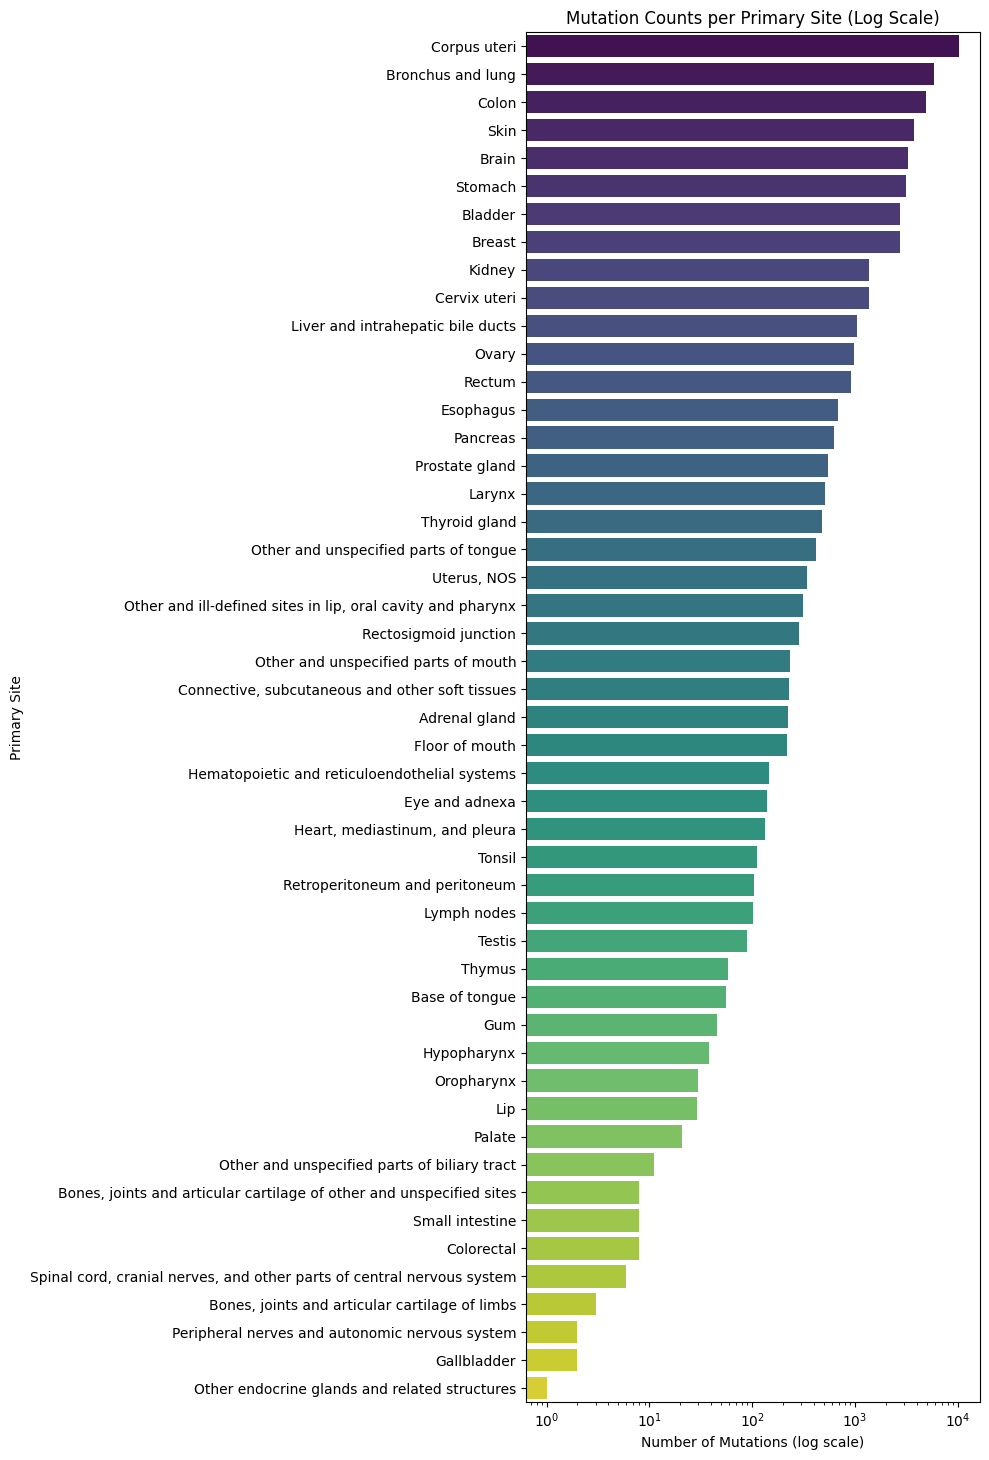

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Count occurrences
counts = df_mut["primary_site"].value_counts()

# Convert counts Series to DataFrame
df_counts = counts.reset_index()
df_counts.columns = ["primary_site", "mutations"]

# Set figure size (scale with number of entries)
plt.figure(figsize=(10, len(df_counts) * 0.3))

# Create horizontal bar plot
sns.barplot(
    data=df_counts,
    x="mutations",
    y="primary_site",
    palette="viridis"
)

# Set x-axis to log scale
plt.xscale("log")

# Labels and layout
plt.title("Mutation Counts per Primary Site (Log Scale)")
plt.xlabel("Number of Mutations (log scale)")
plt.ylabel("Primary Site")
plt.tight_layout()
plt.show()


## 2. Inżynieria cech

In [18]:
!pip install biopython pyranges

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 98.7 MB/s eta 0:00:00


In [19]:
import re 
df = df_mut.rename(columns={'Start_Position': 'Start'})
df = df.rename(columns={'End_Position': 'End'})

In [20]:
df.columns

Index(['project_short_name', 'case_barcode', 'primary_site', 'Hugo_Symbol',
       'Entrez_Gene_Id', 'Center', 'NCBI_Build', 'Chromosome', 'Start', 'End',
       ...
       'callers', 'file_gdc_id', 'muse', 'mutect2', 'pindel', 'varscan2',
       'sample_barcode_tumor', 'sample_barcode_normal',
       'aliquot_barcode_tumor', 'aliquot_barcode_normal'],
      dtype='object', length=152)

In [21]:
!wget http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
!gunzip hg38.fa.gz

--2025-06-29 14:08:58--  http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘hg38.fa.gz’

hg38.fa.gz          100%[===================>] 938.09M   169MB/s    in 5.6s    

2025-06-29 14:09:03 (168 MB/s) - ‘hg38.fa.gz’ saved [983659424/983659424]



In [22]:
import pyranges as pr
import pandas as pd
from Bio import SeqIO

gr = pr.PyRanges(df)
fasta_sequences = SeqIO.to_dict(SeqIO.parse("/kaggle/working/hg38.fa", "fasta"))

## Ekstrakcja motywów mutacyjnych:

In [23]:
def get_cosmic_notation(row, fasta_dict):
    chrom = row.Chromosome  # upewniamy się, że chromosom nie ma prefiksu "chr"
    start = int(row.Start)
    end = int(row.End)
    alt = str(row.Tumor_Seq_Allele2) if pd.notnull(row.Tumor_Seq_Allele2) else None
    variant_type = row.Variant_Type
    cosmic_notation = None

    try:
        seq = fasta_dict[chrom].seq
        context_seq = seq[start-2:end+1].upper()  # np. G[C>T]A -> 1 baza przed i po
        ref_base = seq[start-1:end].upper()  

        # COSMIC-style notacja
        if variant_type == 'SNP':
            # np. G[C>T]A
            cosmic_notation = f"{context_seq[0]}[{ref_base}>{alt}]{context_seq[-1]}"

        elif variant_type == 'DEL':
            if end > start:
                deleted_seq = seq[start-1:end].upper()
            else:
                deleted_seq = ref_base
            cosmic_notation = f"{context_seq[0]}[del{len(deleted_seq)}]{context_seq[-1]}"

        elif variant_type == 'INS':
            inserted_seq = alt
            cosmic_notation = f"{context_seq[0]}[ins{len(inserted_seq)}]{context_seq[-1]}"

        else:
            cosmic_notation = f"UnknownVariantType:{variant_type}"

    except Exception as e:
        cosmic_notation = f"ERROR: {e}"

    return cosmic_notation


In [24]:
df['Mutational_Motif'] = df.apply(lambda row: get_cosmic_notation(row, fasta_sequences), axis=1)

## Genomiczne binowanie:

In [25]:
df['Genomic_Bin'] = df['Chromosome'].astype(str) + '_' + (
    ((df['Start'] - 1) // 1_000_000) * 1_000_000
).astype(str)

## Normalizacja mutacji do pitymidyn, komplementacja:

In [26]:
complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}

def normalize_mutation(mutation):
    match = re.match(r"([ATGC])([ATGC]>[ATGC])([ATGC]>[ATGC])([ATGC])", mutation)
    if match:
        ref, change, alt = match.groups()
        ref_from, ref_to = change.split('>')

        if ref_from not in ['C', 'T']:
            ref_from = complement[ref_from]
            ref_to = complement[ref_to]
            ref = complement[alt]
            alt = complement[ref]

        return f"{ref}[{ref_from}>{ref_to}]{alt}"

    return mutation

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer

mutations = ['A[A>C]A', 'G[G>A]T', 'C[C>T]G', 'T[T>G]T']

df['MutationType'] = df['Mutational_Motif'].apply(normalize_mutation)

top_sites = df['primary_site'].value_counts().nlargest(24).index

filtered_df = df[df['primary_site'].isin(top_sites)]

filtered_df['primary_site_cat'] = filtered_df['primary_site'].astype('category').cat.codes


grouped_mutations_df = filtered_df.groupby('case_barcode').agg({
    'Mutational_Motif': list,
    'Genomic_Bin': list,
    'Hugo_Symbol': list,
    'primary_site': 'first',
    'primary_site_cat': 'first',
}).reset_index()



2025-06-29 14:09:57.353030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751206197.540385      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751206197.592929      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_19/1731204343.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['primary_site_cat'] = filtered_df['primary_site'].astype('category').cat.codes


### Normalizacja ekspresji RNA przez logarytmowanie 

In [28]:
import numpy as np

df_expr['tpm_unstranded'] = df_expr['tpm_unstranded'].apply(lambda x: np.log1p(x))

In [29]:
df_expr.shape

(1445931, 3)

### Duplicate deletion  
Some case_barcode entries may have multiple tpm_unstranded values for the same gene_name. The objective is to achieve a data frame grouped by case_barcode where the tpm_unstranded vector keeps its values in a list, where each list index corresponds to a specific gene and the gene order is the same for all rows.

In [30]:
badly_grouped = df_expr.groupby('case_barcode').agg({
    'tpm_unstranded': list,
    'gene_name': list
}).reset_index()
badly_grouped.head

<bound method NDFrame.head of        case_barcode                                     tpm_unstranded  \
0      TCGA-02-0003  [2.559024145705895, 2.0067902004317144, 3.4190...   
1      TCGA-02-0016  [7.623641213373473, 6.179794889934382, 2.93729...   
2      TCGA-02-0026  [3.252213884478711, 2.8253649789948887, 3.3315...   
3      TCGA-02-0033  [2.465604897033222, 3.8236834741046226, 2.4913...   
4      TCGA-02-0038  [3.187240668494587, 3.1939640882719176, 3.6423...   
...             ...                                                ...   
10506  TCGA-ZS-A9CF  [1.8214800706771364, 0.4665602074679753, 2.306...   
10507  TCGA-ZS-A9CG  [1.2586314296297347, 2.068898660303277, 0.7082...   
10508  TCGA-ZT-A8OM  [0.5943760184599247, 1.1593937609279688, 3.248...   
10509  TCGA-ZU-A8S4  [2.8861908076695646, 1.2845938062935514, 2.134...   
10510  TCGA-ZX-AA5X  [2.58435975098136, 1.5527829012775214, 2.43793...   

                                               gene_name  
0      [TSC1, BCL2, KD

To achieve the effect mentioned above, I'm using a median of all duplicate values for case_barcode + gene_name pairs

In [31]:
temp = df_expr.groupby(['case_barcode', 'gene_name'])['tpm_unstranded'].agg(['median'])#.sort_values(0, ascending=False)
print(temp.reset_index().groupby(['case_barcode']).agg('count'))
temp = temp.reset_index()
print(temp)
#X_rna_df = temp.pivot(index='case_barcode', columns='gene_name', values='median')
#X_rna_df.fillna(0, inplace=True)
#print(X_rna_df)

              gene_name  median
case_barcode                   
TCGA-02-0003        125     125
TCGA-02-0016        125     125
TCGA-02-0026        125     125
TCGA-02-0033        125     125
TCGA-02-0038        125     125
...                 ...     ...
TCGA-ZS-A9CF        125     125
TCGA-ZS-A9CG        125     125
TCGA-ZT-A8OM        125     125
TCGA-ZU-A8S4        125     125
TCGA-ZX-AA5X        125     125

[10511 rows x 2 columns]
         case_barcode gene_name    median
0        TCGA-02-0003      ABL1  3.611361
1        TCGA-02-0003    ACVR1B  3.060860
2        TCGA-02-0003      AKT1  3.204809
3        TCGA-02-0003       ALK  1.604908
4        TCGA-02-0003     AMER1  1.580442
...               ...       ...       ...
1313870  TCGA-ZX-AA5X      TSC1  2.251881
1313871  TCGA-ZX-AA5X      TSHR  0.051263
1313872  TCGA-ZX-AA5X     U2AF1  0.539180
1313873  TCGA-ZX-AA5X       VHL  3.609474
1313874  TCGA-ZX-AA5X       WT1  0.869325

[1313875 rows x 3 columns]


In [32]:
grouped_expression_df = temp.groupby('case_barcode').agg({
    'gene_name': list,
    'median': list,
}).reset_index()

In [33]:
grouped_expression_df['median'].agg([len])

/tmp/ipykernel_19/1779779152.py:1: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  grouped_expression_df['median'].agg([len])


,len
0,125
1,125
2,125
3,125
4,125
...,...
10506,125
10507,125
10508,125
10509,125


In [34]:
# Step 1: Flatten the index
#temp_flat = temp.reset_index()

# Step 2: Pivot to get genes as columns
#pivot_df = temp_flat.pivot(index='case_barcode', columns='gene_name', values=('tpm_unstranded', 'median'))

# Step 3: Ensure consistent gene order (optional but recommended)
#pivot_df = pivot_df.sort_index(axis=1)

# Step 4: Create the desired dataframe
#df_rna = pivot_df.apply(lambda row: row.tolist(), axis=1).reset_index()
#df_rna.columns = ['case_barcode', 'rna_expression']


In [35]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#X_rna_scaled = scaler.fit_transform(X_rna)  # X_rna shape: (samples, genes)

### Multiomic data frame: 

In [36]:
grouped_mutations_df.shape

(8073, 6)

In [37]:
grouped_df = pd.merge(grouped_mutations_df, grouped_expression_df, on="case_barcode", suffixes=('_mutation', '_expression'))

In [38]:
grouped_df

,case_barcode,Mutational_Motif,Genomic_Bin,Hugo_Symbol,primary_site,primary_site_cat,gene_name,median
0,TCGA-02-0003,"[G[G>T]T, C[G>A]G, G[G>A]G, T[G>A]C]","[chr17_7000000, chr17_7000000, chr5_68000000, ...","[TP53, TP53, PIK3R1, EGFR]",Brain,1,"[ABL1, ACVR1B, AKT1, ALK, AMER1, APC, AR, ARID...","[3.611361057684199, 3.0608596837623514, 3.2048..."
1,TCGA-02-0033,"[T[G>T]G, T[G>A]A, C[C>T]A, C[C>T]G]","[chr10_121000000, chr3_179000000, chr13_480000...","[FGFR2, PIK3CA, RB1, TP53]",Brain,1,"[ABL1, ACVR1B, AKT1, ALK, AMER1, APC, AR, ARID...","[3.345050221039154, 3.040112729234723, 3.23313..."
2,TCGA-02-0047,[A[T>A]G],[chr3_179000000],[PIK3CA],Brain,1,"[ABL1, ACVR1B, AKT1, ALK, AMER1, APC, AR, ARID...","[3.995714579070823, 3.4241460494155675, 3.4238..."
3,TCGA-02-0055,"[C[del38]A, A[C>T]A, G[C>T]G, A[A>G]C]","[chr13_48000000, chr17_7000000, chr20_32000000...","[RB1, TP53, ASXL1, PTEN]",Brain,1,"[ABL1, ACVR1B, AKT1, ALK, AMER1, APC, AR, ARID...","[3.613908816960211, 2.5802467492090617, 3.0212..."
4,TCGA-02-2466,"[T[G>A]A, C[T>G]C, C[G>A]A, G[C>T]C]","[chr6_33000000, chr16_3000000, chr19_11000000,...","[DAXX, CREBBP, SMARCA4, EGFR]",Brain,1,"[ABL1, ACVR1B, AKT1, ALK, AMER1, APC, AR, ARID...","[3.41197575243391, 2.6808708324286687, 2.68120..."
...,...,...,...,...,...,...,...,...
7722,TCGA-ZS-A9CE,"[T[C>A]C, A[del1]G, G[C>T]C, G[A>C]G]","[chr1_77000000, chr1_77000000, chr4_152000000,...","[FUBP1, FUBP1, FBXW7, PIK3CA]",Liver and intrahepatic bile ducts,11,"[ABL1, ACVR1B, AKT1, ALK, AMER1, APC, AR, ARID...","[2.548640159490796, 3.4134519863291546, 3.0836..."
7723,TCGA-ZS-A9CF,"[C[C>T]C, C[C>T]C, T[T>C]T, T[T>C]T]","[chr5_150000000, chr5_150000000, chr20_3200000...","[CSF1R, CSF1R, ASXL1, ASXL1]",Liver and intrahepatic bile ducts,11,"[ABL1, ACVR1B, AKT1, ALK, AMER1, APC, AR, ARID...","[3.088381368353286, 3.8010003458022124, 2.7798..."
7724,TCGA-ZS-A9CG,"[G[ins7]A, A[T>A]G, T[C>T]C, C[A>T]G, T[G>A]G]","[chr11_119000000, chr7_129000000, chr6_1060000...","[CBL, SMO, PRDM1, BAP1, CTNNB1]",Liver and intrahepatic bile ducts,11,"[ABL1, ACVR1B, AKT1, ALK, AMER1, APC, AR, ARID...","[2.8677170673313586, 3.2608350924482234, 2.589..."
7725,TCGA-ZU-A8S4,"[C[C>A]A, A[del5]C, C[A>T]C]","[chr7_152000000, chr1_26000000, chr7_140000000]","[KMT2C, ARID1A, BRAF]",Liver and intrahepatic bile ducts,11,"[ABL1, ACVR1B, AKT1, ALK, AMER1, APC, AR, ARID...","[2.9667274697173696, 2.7056751675720454, 3.104..."


In [39]:
tokenizer_bin = Tokenizer(filters='', lower=False, split=' ', oov_token="<OOV>")
tokenizer_bin.fit_on_texts(df['Genomic_Bin'].astype(str).to_list())

tokenizer_gene = Tokenizer(filters='', lower=False, split=' ', oov_token="<OOV>")
tokenizer_gene.fit_on_texts(df['Hugo_Symbol'].astype(str).to_list())

tokenizer_motif = Tokenizer(filters='', lower=False, split=' ', oov_token="<OOV>")
tokenizer_motif.fit_on_texts(df['Mutational_Motif'].astype(str).to_list())

### Tokenizacja genów, motywów i binów:

In [40]:
import tensorflow as tf

def to_matrix(tokenizer, texts):
    sequences = tokenizer.texts_to_sequences(texts)
    count_vectors = np.zeros((len(texts), len(tokenizer.word_index) + 1))

    for i, seq in enumerate(sequences):
        for token in seq:
            count_vectors[i, token] += 1

    return count_vectors

In [41]:
def prepare_data_for(df, tokenizer_bin, tokenizer_gene):
    X_bin = to_matrix(tokenizer_bin, df['Genomic_Bin'])
    X_gene = to_matrix(tokenizer_gene, df['Hugo_Symbol'])
    X_motif = to_matrix(tokenizer_motif, df['Mutational_Motif'])
    X_rna = np.array(df['median'].to_list())

    return X_bin, X_gene, X_motif, X_rna

Końcowe zbiory cech


X_bin, X_gene, X_motif, X_rna  

In [42]:
X_bin, X_gene, X_motif, X_rna = prepare_data_for(grouped_df, tokenizer_bin, tokenizer_gene)


### Konkatenacja wektorów:  
Potrzebny jeszcze wektor motywów

In [43]:
print(X_bin.shape)
print(X_gene.shape)
print(X_motif.shape)
print(X_rna.shape)
print(X_bin.shape[1] + X_gene.shape[1] + X_motif.shape[1] + X_rna.shape[1])
X = np.concatenate([X_bin, X_gene, X_motif, X_rna], axis=1)


(7727, 135)
(7727, 127)
(7727, 794)
(7727, 125)
1181


In [44]:
X.shape

(7727, 1181)

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Etykiety: y_primary_site

In [46]:
y_primary_site = grouped_df['primary_site_cat'].values
y_primary_site.shape

(7727,)

## 3. Budowa i trening modelu  


### 1. Architektura  
• Wejścia dla każdej grupy cech (warstwy Dense).  
• Laczenie (Concatenate) oraz warstwy ukryte.  
• Wyjście: softmax nad klasami lokalizacji pierwotnej.  

In [47]:
import torch
import torch.nn as nn

class MultiInputModel(nn.Module):
    def __init__(self, dim_bin, dim_gene, dim_motif, dim_rna, hidden=128, output_dim=24):
        super(MultiInputModel, self).__init__()

        # Separate pathways for each feature group
        self.fc_bin = nn.Sequential(
            nn.Linear(dim_bin, hidden),
            nn.ReLU()
        )
        self.fc_gene = nn.Sequential(
            nn.Linear(dim_gene, hidden),
            nn.ReLU()
        )
        self.fc_motif = nn.Sequential(
            nn.Linear(dim_motif, hidden),
            nn.ReLU()
        )
        self.fc_rna = nn.Sequential(
            nn.Linear(dim_rna, hidden),
            nn.ReLU()
        )

        # Combined pathway
        self.fc_combined = nn.Sequential(
            nn.Linear(hidden * 4, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, X_bin, X_gene, X_motif, X_rna):
        out_bin = self.fc_bin(X_bin)
        out_gene = self.fc_gene(X_gene)
        out_motif = self.fc_motif(X_motif)
        out_rna = self.fc_rna(X_rna)

        # Concatenate all processed features
        out = torch.cat([out_bin, out_gene, out_motif, out_rna], dim=1)
        out = self.fc_combined(out)
        return out

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Używane urządzenie:", device)

Używane urządzenie: cuda


## Model building and training  
### 2. Trening  
• Podzial na zbiór treningowy/testowy 80/20.  
• Optymalizator: Adam, strata: categorical crossentropy.  
• Monitorowanie loss i accuracy.  
• Uwzglednienie niezbalansowanych etykiet.  

### Training and testing (and validation) sets

In [49]:
# Train, test and validation sets
from sklearn.model_selection import train_test_split

# create test and train sets with respect to imbalanced labels
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_primary_site, test_size=0.2, stratify=y_primary_site, random_state=42) 

# create train and validation sets with respect to imbalanced labels
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42) 

print(X_train.shape,y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(4944, 1181) (4944,) (1546, 1181) (1546,) (1237, 1181) (1237,)


### Loss and optimizer

In [50]:
model = MultiInputModel(X_bin.shape[1], X_gene.shape[1], X_motif.shape[1], X_rna.shape[1]).to(device)

# Funkcja straty i optymalizator
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Loss and accuracy monitoring

In [51]:
def train_model(model):
    # Initialize history
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }
    
    for epoch in range(500):
        optimizer.zero_grad()
        model.train()
        
        X_train_tensor = X_train_tensor.to(device)
        y_train_tensor = y_train_tensor.to(device)

        # Forward pass
        y_pred_train = model(*X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
    
        loss.backward()
        optimizer.step()
        
        # Compute training accuracy
        train_acc = (y_pred_train.argmax(dim=1) == y_train_tensor.argmax(dim=1)).float().mean().item()

        # Validation
        model.eval()
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    
        with torch.no_grad():
            y_pred_val = model(X_val_tensor)
            val_loss = criterion(y_pred_val, y_val_tensor)
            val_acc = (y_pred_val.argmax(dim=1) == y_val_tensor.argmax(dim=1)).float().mean().item()
        
        # Store in history
        history['loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
    
        print(f"\nMSE na zbiorze testowym: {val_loss.item():.4f}")
    
    return history


In [52]:
from tensorflow.keras.utils import to_categorical

# Calculate sample counts per class
train_counts = np.count_nonzero(to_categorical(y_train), axis=0) / (0.8*0.8)
test_counts = np.count_nonzero(to_categorical(y_test), axis=0) / 0.2
val_counts = np.count_nonzero(to_categorical(y_val), axis=0) / (0.8*0.2)
total_counts = np.count_nonzero(to_categorical(grouped_df['primary_site_cat'].values), axis=0)

# Combine into a DataFrame
df_counts = pd.DataFrame({
    'Class Index': range(len(total_counts)),
    'Train (scaled)': train_counts,
    'Test (scaled)': test_counts,
    'Validation (scaled)': val_counts,
    'Total': total_counts
})

# Round for easier reading
df_counts = df_counts.round(2)

# Display sorted by Total count or any other logic
print(df_counts.sort_values(by='Total', ascending=False).to_string(index=False))


 Class Index  Train (scaled)  Test (scaled)  Validation (scaled)  Total
           3          956.25          960.0               956.25    957
           2          878.12          880.0               881.25    879
           1          715.62          715.0               718.75    716
           9          550.00          550.0               550.00    550
           7          509.37          510.0               512.50    510
          20          446.87          450.0               450.00    448
           5          415.62          415.0               418.75    416
           0          385.94          385.0               387.50    386
          21          384.37          385.0               387.50    385
          22          376.56          375.0               375.00    376
          11          356.25          355.0               356.25    356
          15          275.00          275.0               275.00    275
          17          265.62          265.0               268.75

The unbalanced classes were taken into acocunt

### Learning curve vs overfitting

In [53]:
# Kompilacja modelu
#model.compile(optimizer='adam',
#              loss='categorical_crossentropy',
#              metrics=['accuracy', 'loss'])

In [54]:
#history = train_model(model)

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------- Split the dataset ------------------------
y_labels = y_primary_site 

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_labels, test_size=0.2, stratify=y_labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Function to split feature groups
def split_inputs(X):
    return (
        torch.tensor(X[:, :135], dtype=torch.float32),
        torch.tensor(X[:, 135:262], dtype=torch.float32),
        torch.tensor(X[:, 262:1056], dtype=torch.float32),
        torch.tensor(X[:, 1056:], dtype=torch.float32)
    )

# Convert and split (so that each trait group has its own input)
X_train_parts = [part.to(device) for part in split_inputs(X_train)]
X_val_parts = [part.to(device) for part in split_inputs(X_val)]
X_test_parts = [part.to(device) for part in split_inputs(X_test)]

y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# ---------------------- Model Definition ------------------------
class MultiInputModel(nn.Module):
    def __init__(self, dim_bin, dim_gene, dim_motif, dim_rna, hidden=128, output_dim=24):
        super(MultiInputModel, self).__init__()

        # Multiple inputs for traits
        self.fc_bin = nn.Sequential(nn.Linear(dim_bin, hidden), nn.ReLU())
        self.fc_gene = nn.Sequential(nn.Linear(dim_gene, hidden), nn.ReLU())
        self.fc_motif = nn.Sequential(nn.Linear(dim_motif, hidden), nn.ReLU())
        self.fc_rna = nn.Sequential(nn.Linear(dim_rna, hidden), nn.ReLU())

        self.fc_combined = nn.Sequential(
            nn.Linear(hidden * 4, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, X_bin, X_gene, X_motif, X_rna):
        out_bin = self.fc_bin(X_bin)
        out_gene = self.fc_gene(X_gene)
        out_motif = self.fc_motif(X_motif)
        out_rna = self.fc_rna(X_rna)
        out = torch.cat([out_bin, out_gene, out_motif, out_rna], dim=1)
        return self.fc_combined(out)

# ---------------------- Initialize ------------------------
model = MultiInputModel(
    dim_bin=X_bin.shape[1],
    dim_gene=X_gene.shape[1],
    dim_motif=X_motif.shape[1],
    dim_rna=X_rna.shape[1]
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------- Training Loop ------------------------
def train_model(model, epochs=100):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        y_pred_train = model(*X_train_parts)
        loss = criterion(y_pred_train, y_train_tensor)
        loss.backward()
        optimizer.step()

        train_acc = (y_pred_train.argmax(dim=1) == y_train_tensor).float().mean().item()

        # Validation
        model.eval()
        with torch.no_grad():
            y_pred_val = model(*X_val_parts)
            val_loss = criterion(y_pred_val, y_val_tensor)
            val_acc = (y_pred_val.argmax(dim=1) == y_val_tensor).float().mean().item()

        history['loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return history

# ---------------------- Train the model ------------------------
history = train_model(model, epochs=100)


Epoch   0 | Loss: 3.1821 | Val Loss: 3.1016 | Train Acc: 0.0625 | Val Acc: 0.1892
Epoch  10 | Loss: 2.2979 | Val Loss: 2.3013 | Train Acc: 0.4365 | Val Acc: 0.4414
Epoch  20 | Loss: 1.4952 | Val Loss: 1.5828 | Train Acc: 0.6865 | Val Acc: 0.6637
Epoch  30 | Loss: 0.8761 | Val Loss: 1.0432 | Train Acc: 0.8169 | Val Acc: 0.7567
Epoch  40 | Loss: 0.5135 | Val Loss: 0.7419 | Train Acc: 0.8766 | Val Acc: 0.8165
Epoch  50 | Loss: 0.3142 | Val Loss: 0.5948 | Train Acc: 0.9221 | Val Acc: 0.8399
Epoch  60 | Loss: 0.2038 | Val Loss: 0.5256 | Train Acc: 0.9472 | Val Acc: 0.8561
Epoch  70 | Loss: 0.1401 | Val Loss: 0.4964 | Train Acc: 0.9676 | Val Acc: 0.8601
Epoch  80 | Loss: 0.0997 | Val Loss: 0.4884 | Train Acc: 0.9794 | Val Acc: 0.8666
Epoch  90 | Loss: 0.0731 | Val Loss: 0.4939 | Train Acc: 0.9873 | Val Acc: 0.8593


## 4. Ocena overfittingu  
### 1. Wizualizacja uczenia  
• Krzywe loss/accuracy dla zbioru treningowego i walidacyjnego.  

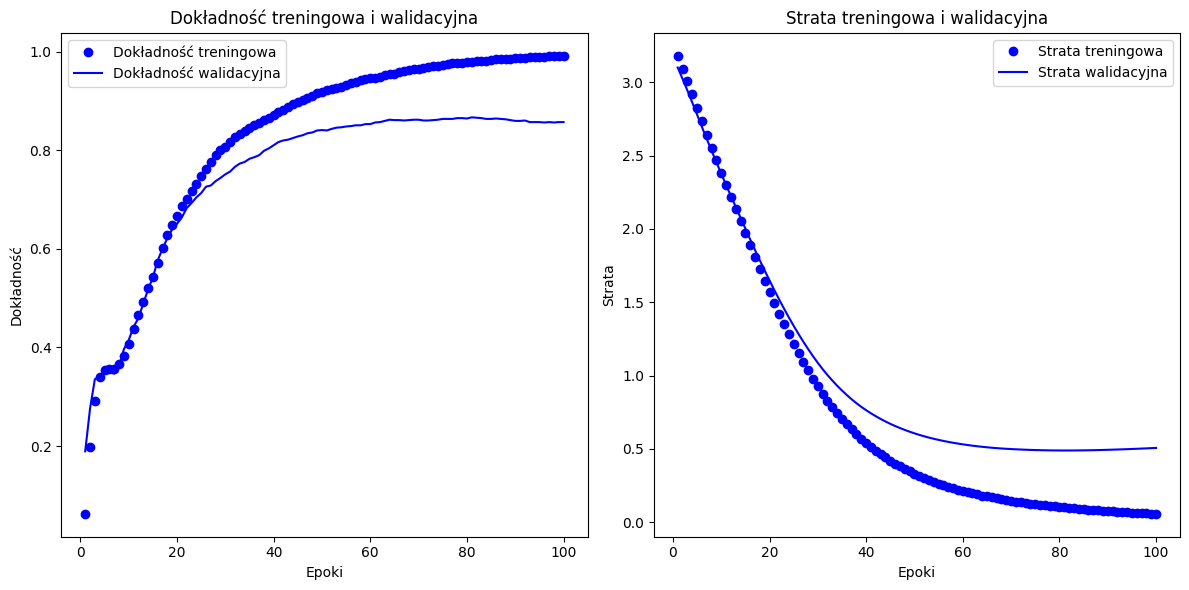

In [56]:
import matplotlib.pyplot as plt

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Dokładność treningowa')
plt.plot(epochs, val_acc, 'b', label='Dokładność walidacyjna')
plt.title('Dokładność treningowa i walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Strata treningowa')
plt.plot(epochs, val_loss, 'b', label='Strata walidacyjna')
plt.title('Strata treningowa i walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.tight_layout()
plt.show()

### 2. Metryki  
• Accuracy, precision, recall, F1 na zbiorze walidacyjnym.  

### 3. Identyfikacja overfittingu  
• Nierozbieżność miedzy strata/train a strata/val.  
• Spadek lub stagnacja accuracy/val przy rosnacym accuracy/train.